In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_auc_score

Следующий блок добавлен на случай, если у вас проблемы с версиями polars, catboost, или в целом с .parquet файлами.

В случае конфликта версий catboost и polars при создании Pool, может потребоваться использовать fallback функцию to_pandas(). Более нигде pandas далее не используется.

In [2]:
import pandas as pd

try:
    import pyarrow
    print("PyArrow is installed. Version:", pyarrow.__version__)
except ModuleNotFoundError:
    print("PyArrow is NOT found in this environment. You installed it in a different one.")

PyArrow is installed. Version: 17.0.0


### Часть 1, смотрим данные

Сперва подгрузим данные и посмотрим с чем нам предстоит работать. 

Участникам предоставляются 2 пары файлов с признаками (train и test):

1. train_main_features.parquet + test_main_features.parquet (199 признаков + ключ)
2. train_extra_features.parquet + test_extra_features.parquet (2241 признак + ключ)


##### Часть 1.1 данные признаков

Попробуем сперва поработать с первым набором (*_main_features.parquet*).

In [3]:
%%time
#train = pl.read_parquet('data/train_main_features.parquet')
#test = pl.read_parquet('data/test_main_features.parquet')

train = pl.read_parquet('/media/dm/1TB/Data Fusion Contest 2026/task2/train_main_features.parquet')
test = pl.read_parquet('/media/dm/1TB/Data Fusion Contest 2026/task2/test_main_features.parquet')

print('Тренировочные данные:', train.shape)
print('Тестовые данные:', test.shape)

Тренировочные данные: (750000, 200)
Тестовые данные: (250000, 200)


In [4]:
train#.head(n = 5)

customer_id,cat_feature_1,cat_feature_2,cat_feature_3,cat_feature_4,cat_feature_5,cat_feature_6,cat_feature_7,cat_feature_8,cat_feature_9,cat_feature_10,cat_feature_11,cat_feature_12,cat_feature_13,cat_feature_14,cat_feature_15,cat_feature_16,cat_feature_17,cat_feature_18,cat_feature_19,cat_feature_20,cat_feature_21,cat_feature_22,cat_feature_23,cat_feature_24,cat_feature_25,cat_feature_26,cat_feature_27,cat_feature_28,cat_feature_29,cat_feature_30,cat_feature_31,cat_feature_32,cat_feature_33,cat_feature_34,cat_feature_35,cat_feature_36,…,num_feature_96,num_feature_97,num_feature_98,num_feature_99,num_feature_100,num_feature_101,num_feature_102,num_feature_103,num_feature_104,num_feature_105,num_feature_106,num_feature_107,num_feature_108,num_feature_109,num_feature_110,num_feature_111,num_feature_112,num_feature_113,num_feature_114,num_feature_115,num_feature_116,num_feature_117,num_feature_118,num_feature_119,num_feature_120,num_feature_121,num_feature_122,num_feature_123,num_feature_124,num_feature_125,num_feature_126,num_feature_127,num_feature_128,num_feature_129,num_feature_130,num_feature_131,num_feature_132
i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1000001,1.0,0.0,2.0,1.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,2.0,0.0,0.0,212.0,0.0,0.0,…,-0.284519,null,-0.004499,null,-0.050159,-0.002297,-0.043592,-0.061488,0.450342,null,0.0,null,-0.060492,-0.279105,null,-0.429813,null,-0.009654,-0.293036,null,-0.493959,-0.019079,null,null,null,null,-0.001357,-0.031281,-0.046146,null,-0.445279,null,null,-0.107666,-0.418616,null,null
1000002,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,212.0,1.0,0.0,…,-0.284519,0.460275,-0.004278,null,-0.556244,-0.002297,-0.043592,-0.061488,1.998252,-0.009552,0.0,-0.005762,-0.060492,-0.279105,null,-0.429813,null,-0.009654,-0.293036,-0.004421,-0.256445,-0.014154,null,-0.24167,null,null,-0.001357,-0.031281,-0.046146,-0.10217,1.550722,null,null,-0.170724,-0.805771,-0.397803,-0.373734
1000003,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,212.0,0.0,0.0,…,-0.284519,-0.264397,-0.004278,null,null,-0.002297,-0.043592,-0.061488,-0.264078,null,0.0,-0.26649,-0.060492,-0.279105,null,-0.429813,null,-0.009654,-0.293036,-0.004421,-0.57313,-0.019124,null,-0.24167,null,null,-0.001357,-0.031281,-0.046146,null,-0.475778,null,null,-0.170724,-0.602005,-0.397803,-0.373734
1000004,1.0,0.0,2.0,1.0,2.0,3.0,2.0,2.0,3.0,2.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,212.0,0.0,0.0,…,-0.284519,null,-0.004499,null,null,-0.002297,-0.043592,-0.061488,0.688482,-0.009552,0.0,null,-0.060492,null,null,-0.429813,null,-0.009654,-0.293036,null,-0.57313,null,null,-0.505441,null,0.714631,-0.001357,-0.031281,-0.046146,null,-0.475778,0.111196,0.116695,null,-0.724265,null,null
1000005,1.0,2.0,0.0,1.0,0.0,3.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,212.0,2.0,2.0,…,-0.284519,-0.264397,-0.004499,null,null,-0.002297,-0.043592,null,-0.264078,null,0.0,-0.26649,null,-0.279105,null,-0.429813,null,-0.009654,-0.293036,-0.004421,-0.57313,-0.018674,null,null,null,null,null,null,-0.046146,null,null,null,null,-0.107666,null,-0.397803,-0.373734
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1749996,1.0,0.0,2.0,0.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,212.0,0.0,0.0,…,null,null,-0.004499

Легенда гласит, что в данных достаточно много пропусков. 

Так ли это?

In [5]:
missing_values = (
    train.null_count()
    .unpivot(variable_name="Column", value_name="Missing Values")
    .filter(pl.col("Missing Values") > 0)
    .sort("Missing Values", descending=True)
)

print('\nКоличество пропусков в признаках:\n', missing_values)


Количество пропусков в признаках:
 shape: (132, 2)
┌─────────────────┬────────────────┐
│ Column          ┆ Missing Values │
│ ---             ┆ ---            │
│ str             ┆ u64            │
╞═════════════════╪════════════════╡
│ num_feature_43  ┆ 749166         │
│ num_feature_54  ┆ 748897         │
│ num_feature_64  ┆ 748761         │
│ num_feature_34  ┆ 748228         │
│ num_feature_118 ┆ 747082         │
│ …               ┆ …              │
│ num_feature_27  ┆ 31045          │
│ num_feature_58  ┆ 18722          │
│ num_feature_76  ┆ 18542          │
│ num_feature_62  ┆ 18540          │
│ num_feature_98  ┆ 3215           │
└─────────────────┴────────────────┘


Нам также известно, что часть признаков в данных — категориальная. 
По легенде их можно найти по названиям "cat_feature".

Эти категориальные признаки стоит отдельно выделить и сохранить для Catboost. 

In [6]:
cat_feature_names = [
    col_name for col_name in train.columns 
    if col_name.startswith("cat_feature")
]
cat_feature_names

['cat_feature_1',
 'cat_feature_2',
 'cat_feature_3',
 'cat_feature_4',
 'cat_feature_5',
 'cat_feature_6',
 'cat_feature_7',
 'cat_feature_8',
 'cat_feature_9',
 'cat_feature_10',
 'cat_feature_11',
 'cat_feature_12',
 'cat_feature_13',
 'cat_feature_14',
 'cat_feature_15',
 'cat_feature_16',
 'cat_feature_17',
 'cat_feature_18',
 'cat_feature_19',
 'cat_feature_20',
 'cat_feature_21',
 'cat_feature_22',
 'cat_feature_23',
 'cat_feature_24',
 'cat_feature_25',
 'cat_feature_26',
 'cat_feature_27',
 'cat_feature_28',
 'cat_feature_29',
 'cat_feature_30',
 'cat_feature_31',
 'cat_feature_32',
 'cat_feature_33',
 'cat_feature_34',
 'cat_feature_35',
 'cat_feature_36',
 'cat_feature_37',
 'cat_feature_38',
 'cat_feature_39',
 'cat_feature_40',
 'cat_feature_41',
 'cat_feature_42',
 'cat_feature_43',
 'cat_feature_44',
 'cat_feature_45',
 'cat_feature_46',
 'cat_feature_47',
 'cat_feature_48',
 'cat_feature_49',
 'cat_feature_50',
 'cat_feature_51',
 'cat_feature_52',
 'cat_feature_53',
 '

In [7]:
train = train.with_columns(
    pl.col(cat_feature_names).cast(pl.Int32)
)
train 

customer_id,cat_feature_1,cat_feature_2,cat_feature_3,cat_feature_4,cat_feature_5,cat_feature_6,cat_feature_7,cat_feature_8,cat_feature_9,cat_feature_10,cat_feature_11,cat_feature_12,cat_feature_13,cat_feature_14,cat_feature_15,cat_feature_16,cat_feature_17,cat_feature_18,cat_feature_19,cat_feature_20,cat_feature_21,cat_feature_22,cat_feature_23,cat_feature_24,cat_feature_25,cat_feature_26,cat_feature_27,cat_feature_28,cat_feature_29,cat_feature_30,cat_feature_31,cat_feature_32,cat_feature_33,cat_feature_34,cat_feature_35,cat_feature_36,…,num_feature_96,num_feature_97,num_feature_98,num_feature_99,num_feature_100,num_feature_101,num_feature_102,num_feature_103,num_feature_104,num_feature_105,num_feature_106,num_feature_107,num_feature_108,num_feature_109,num_feature_110,num_feature_111,num_feature_112,num_feature_113,num_feature_114,num_feature_115,num_feature_116,num_feature_117,num_feature_118,num_feature_119,num_feature_120,num_feature_121,num_feature_122,num_feature_123,num_feature_124,num_feature_125,num_feature_126,num_feature_127,num_feature_128,num_feature_129,num_feature_130,num_feature_131,num_feature_132
i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1000001,1,0,2,1,2,3,2,2,4,2,0,0,0,1,2,0,2,2,2,0,0,0,2,0,0,0,1,2,1,2,2,0,0,212,0,0,…,-0.284519,null,-0.004499,null,-0.050159,-0.002297,-0.043592,-0.061488,0.450342,null,0.0,null,-0.060492,-0.279105,null,-0.429813,null,-0.009654,-0.293036,null,-0.493959,-0.019079,null,null,null,null,-0.001357,-0.031281,-0.046146,null,-0.445279,null,null,-0.107666,-0.418616,null,null
1000002,1,0,0,1,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,212,1,0,…,-0.284519,0.460275,-0.004278,null,-0.556244,-0.002297,-0.043592,-0.061488,1.998252,-0.009552,0.0,-0.005762,-0.060492,-0.279105,null,-0.429813,null,-0.009654,-0.293036,-0.004421,-0.256445,-0.014154,null,-0.24167,null,null,-0.001357,-0.031281,-0.046146,-0.10217,1.550722,null,null,-0.170724,-0.805771,-0.397803,-0.373734
1000003,1,0,0,1,0,3,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,212,0,0,…,-0.284519,-0.264397,-0.004278,null,null,-0.002297,-0.043592,-0.061488,-0.264078,null,0.0,-0.26649,-0.060492,-0.279105,null,-0.429813,null,-0.009654,-0.293036,-0.004421,-0.57313,-0.019124,null,-0.24167,null,null,-0.001357,-0.031281,-0.046146,null,-0.475778,null,null,-0.170724,-0.602005,-0.397803,-0.373734
1000004,1,0,2,1,2,3,2,2,3,2,0,0,0,1,2,2,2,2,2,0,0,2,2,0,0,0,0,2,1,2,2,0,0,212,0,0,…,-0.284519,null,-0.004499,null,null,-0.002297,-0.043592,-0.061488,0.688482,-0.009552,0.0,null,-0.060492,null,null,-0.429813,null,-0.009654,-0.293036,null,-0.57313,null,null,-0.505441,null,0.714631,-0.001357,-0.031281,-0.046146,null,-0.475778,0.111196,0.116695,null,-0.724265,null,null
1000005,1,2,0,1,0,3,0,0,2,1,2,2,2,0,1,0,0,0,0,2,2,2,0,2,2,2,2,0,0,0,0,2,2,212,2,2,…,-0.284519,-0.264397,-0.004499,null,null,-0.002297,-0.043592,null,-0.264078,null,0.0,-0.26649,null,-0.279105,null,-0.429813,null,-0.009654,-0.293036,-0.004421,-0.57313,-0.018674,null,null,null,null,null,null,-0.046146,null,null,null,null,-0.107666,null,-0.397803,-0.373734
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1749996,1,0,2,0,2,3,2,2,4,2,0,0,0,1,2,0,2,2,2,0,0,2,2,0,0,0,0,2,1,2,2,0,0,212,0,0,…,null,null,-0.004499,-0.150243,null,null,null,2.831928,null,null,null,null,-0.060492,null,null,null,null,null,null,null,null,-0.019236,null,-0.505441,null,null,-0.001357,-0.031281,null,null,-0.475778,null,null,null,0.335315,null,null
1749997,1,0,2,1,2,3,2,2,2,2,0,0,0,1,2,0,2,2,2,0,0,0,2,0,0,0,0,2,1,2,2,0,0,212,1,0,…,-0.284519,null,-0.004499,null,-0.510019,-0.002297,-0.043592,-0.061488,-0.264078,-0.009552,0.0,null,-0.060492,-0.279105,null,2.155184,n

##### Часть 1.2 целевые переменные

В задаче предоставлена информация о 41 банковском продукте. 

Информацию о наличии каждого продукта требуется классифицровать по отдельности, в рамках multi-label постановки.

In [8]:
target = pl.read_parquet('/media/dm/1TB/Data Fusion Contest 2026/task2/train_target.parquet')
target
#shape: (750_000, 42)

customer_id,target_1_1,target_1_2,target_1_3,target_1_4,target_1_5,target_2_1,target_2_2,target_2_3,target_2_4,target_2_5,target_2_6,target_2_7,target_2_8,target_3_1,target_3_2,target_3_3,target_3_4,target_3_5,target_4_1,target_5_1,target_5_2,target_6_1,target_6_2,target_6_3,target_6_4,target_6_5,target_7_1,target_7_2,target_7_3,target_8_1,target_8_2,target_8_3,target_9_1,target_9_2,target_9_3,target_9_4,target_9_5,target_9_6,target_9_7,target_9_8,target_10_1
i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1749996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1749997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1749998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
target.head(n = 5)

customer_id,target_1_1,target_1_2,target_1_3,target_1_4,target_1_5,target_2_1,target_2_2,target_2_3,target_2_4,target_2_5,target_2_6,target_2_7,target_2_8,target_3_1,target_3_2,target_3_3,target_3_4,target_3_5,target_4_1,target_5_1,target_5_2,target_6_1,target_6_2,target_6_3,target_6_4,target_6_5,target_7_1,target_7_2,target_7_3,target_8_1,target_8_2,target_8_3,target_9_1,target_9_2,target_9_3,target_9_4,target_9_5,target_9_6,target_9_7,target_9_8,target_10_1
i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Давайте поверхностно посмотрим на то. с чем нам предстоит работать

In [10]:
target_columns = [col for col in target.columns if col.startswith("target")]
target_columns

['target_1_1',
 'target_1_2',
 'target_1_3',
 'target_1_4',
 'target_1_5',
 'target_2_1',
 'target_2_2',
 'target_2_3',
 'target_2_4',
 'target_2_5',
 'target_2_6',
 'target_2_7',
 'target_2_8',
 'target_3_1',
 'target_3_2',
 'target_3_3',
 'target_3_4',
 'target_3_5',
 'target_4_1',
 'target_5_1',
 'target_5_2',
 'target_6_1',
 'target_6_2',
 'target_6_3',
 'target_6_4',
 'target_6_5',
 'target_7_1',
 'target_7_2',
 'target_7_3',
 'target_8_1',
 'target_8_2',
 'target_8_3',
 'target_9_1',
 'target_9_2',
 'target_9_3',
 'target_9_4',
 'target_9_5',
 'target_9_6',
 'target_9_7',
 'target_9_8',
 'target_10_1']

In [11]:
target_col_means = (
    target.select(pl.col(target_columns).mean())
    .transpose(include_header = True, column_names = ["Mean"])
    .rename({"column": "Target"})
    #.sort("Sum", descending=True)
)

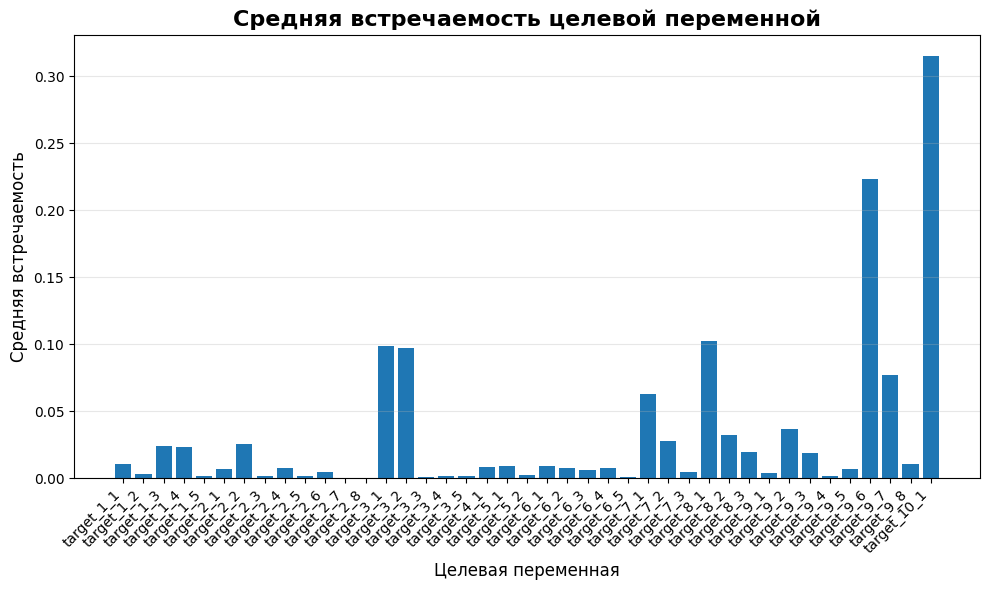

In [12]:
plt.figure(figsize = (10, 6))

bars = plt.bar(target_col_means["Target"], target_col_means["Mean"])

plt.title("Средняя встречаемость целевой переменной", fontsize = 16, fontweight='bold')
plt.xlabel("Целевая переменная", fontsize = 12)
plt.ylabel("Средняя встречаемость", fontsize = 12)
plt.xticks(rotation = 45, ha = 'right', fontsize = 10)
plt.grid(axis = 'y', alpha = 0.3)

plt.tight_layout()
plt.show()

Выглядит интересно. И несбалансированно :)

Интересно, а что у них с совместной встречаемостью?

In [14]:
target_row_sums = target.select(
    pl.sum_horizontal(target_columns).alias("row_sum")
)

target_row_sums.describe()

statistic,row_sum
str,f64
"""count""",750000.0
"""null_count""",0.0
"""mean""",1.303459
"""std""",0.716945
"""min""",1.0
"""25%""",1.0
"""50%""",1.0
"""75%""",1.0
"""max""",11.0


In [15]:
target_corr_matrix = (
    target.select(target_columns)
    .corr()
    .to_numpy()
)

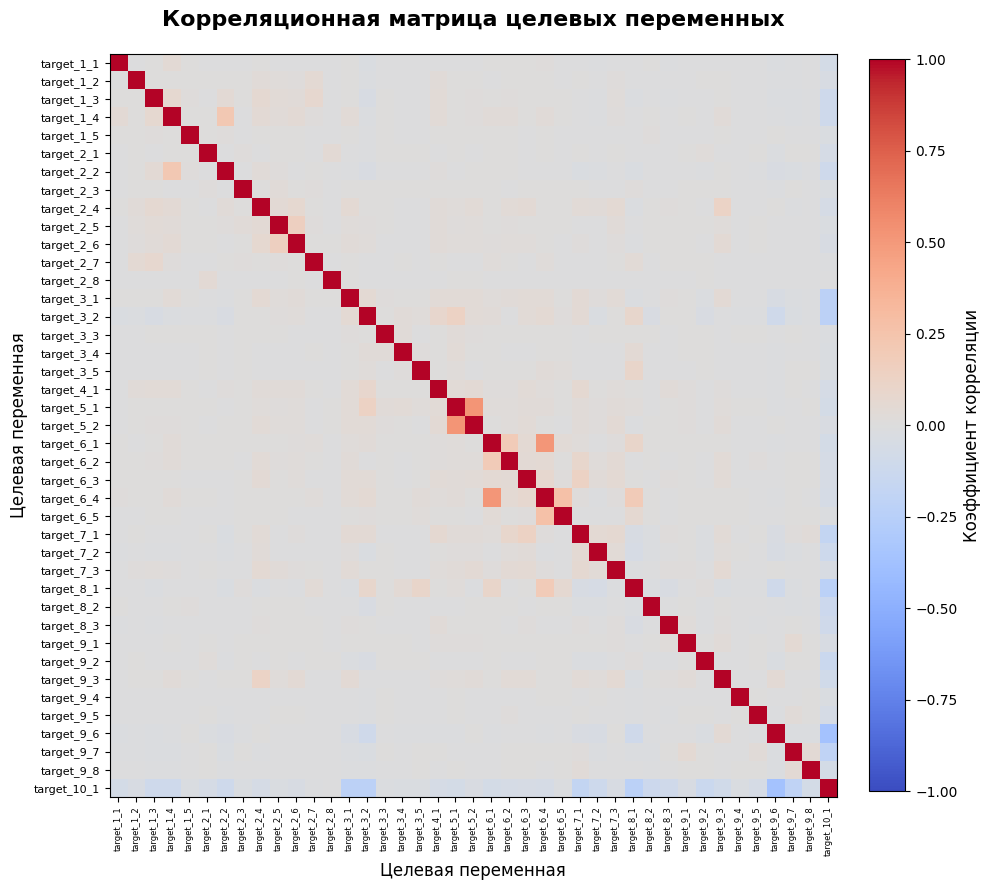

In [16]:
plt.figure(figsize=(10, 9))
im = plt.imshow(target_corr_matrix, cmap = 'coolwarm', vmin = -1, vmax = 1, aspect = 'auto')

cbar = plt.colorbar(im, fraction = 0.046, pad = 0.04)
cbar.set_label('Коэффициент корреляции', fontsize = 12)

plt.title("Корреляционная матрица целевых переменных", fontsize = 16, fontweight = 'bold', pad = 20)
plt.xlabel("Целевая переменная", fontsize = 12)
plt.ylabel("Целевая переменная", fontsize = 12)

plt.xticks(np.arange(len(target_columns)), target_columns, rotation = 90, fontsize = 6)
plt.yticks(np.arange(len(target_columns)), target_columns, fontsize = 8)

plt.tight_layout()
plt.show()

Кажется, тут есть с чем можно работать. 

- На первый взгляд, есть выделяющаяся target_10_1 с отрицательной корреляцией к остальным целевым переменным.
- Внутри целевых переменных с 3 по 7 группу есть заметная внутри-групповая корреляция.
- Небольшая корреляция есть и между целевыми переменными из 1 и 2 групп, в частности между target_1_4 и target_2_2.

В дальнейшей работе это все можно было бы учесть и покопать глубже. Но сейчас нужно подготовить решение :)

### Часть 2, обучаем Catboost

К счастью для нас, Catboost умеет "из коробки" работать и с пропусками, и (важно для нас) с multi-class и multi-label классификацией.

Попробуем обучить модель "в лоб", оставив более интересные возможности и надстройки для участников соревнования :)


##### Часть 2.1 подготовка данных

- Опустим сам customer_id
- Не забудем про ранее сохраненные категориальные признаки
- Найдем в документации Catboost настройку "MultiLogLoss"
- Будем осторожны в первом подходе к снаряду, так как деревьев будет строиться много

In [27]:
%%time
limit=500000
limit=700000
train_pool = Pool(data = train[:limit].drop("customer_id").to_pandas(), 
                  label = target[:limit].drop("customer_id").to_pandas(), 
                  cat_features = cat_feature_names)

valid_pool = Pool(data = train[limit:].drop("customer_id").to_pandas(), 
                  label = target[limit:].drop("customer_id").to_pandas(), 
                  cat_features = cat_feature_names)

CPU times: user 9.98 s, sys: 1.31 s, total: 11.3 s
Wall time: 6.69 s


In [33]:
#from sklearn.metrics import roc_auc_score
#roc_auc_score(y_true, y_pred, average="macro")

import numpy as np
from catboost import MultiTargetCustomMetric
from sklearn.metrics import f1_score

class CustomMultiLabelF1(MultiTargetCustomMetric):
    def is_max_optimal(self):
        # Higher F1 score is better
        return True

    def evaluate(self, approxes, target, weight):
        # approxes is a list of lists/arrays, where the outer list corresponds to each label, 
        # and the inner array contains predictions for each object. We need to reorient it.
        # CatBoost approxes for multilabel is organized as [labels, objects]
        # We need to transpose for typical sklearn metrics usage: [objects, labels]
        y_pred_raw = np.array(approxes).T
        y_true = np.array(target).T

        # Apply a threshold to get binary predictions (e.g., threshold at 0 for raw scores)
        y_pred = (y_pred_raw > 0).astype(int) 

        # Calculate F1 for each sample or an overall micro/macro F1
        # For overall micro F1, flatten the arrays
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
        
        # Using micro F1 as an example; you can change this to 'macro', 'weighted', or 'samples'
        try:
            f1 = f1_score(y_true_flat, y_pred_flat, average='micro')
        except ValueError:
            # Handle cases with no positive samples
            f1 = 0.0
            
        # The sum of errors (in this case, we use 1 - F1 since lower is "error")
        # However, it's easier to just return the value and total count and handle it in get_final_error
        # F1 is the value we want to track. The 'error' variable in get_final_error will be the sum of this value across processes.

        # Let's use F1 as the "error" (incorrect term here, but it's the value to be averaged)
        # and 1 as the weight (total count for averaging)
        return f1 * len(y_true_flat), len(y_true_flat)

    def get_final_error(self, error, weight):
        # Calculate the final average F1 score
        return error / (weight + 1e-38) # Add epsilon to avoid division by zero

class CustomMultiLabelAUC(MultiTargetCustomMetric):
    def is_max_optimal(self):
        # Higher F1 score is better
        return True

    def evaluate(self, approxes, target, weight):
        # approxes is a list of lists/arrays, where the outer list corresponds to each label, 
        # and the inner array contains predictions for each object. We need to reorient it.
        # CatBoost approxes for multilabel is organized as [labels, objects]
        # We need to transpose for typical sklearn metrics usage: [objects, labels]
        y_pred_raw = np.array(approxes).T
        y_true = np.array(target).T

        # Apply a threshold to get binary predictions (e.g., threshold at 0 for raw scores)
        y_pred = (y_pred_raw > 0).astype(int) 

        # Calculate F1 for each sample or an overall micro/macro F1
        # For overall micro F1, flatten the arrays
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
        
        # Using micro F1 as an example; you can change this to 'macro', 'weighted', or 'samples'
        try:
            f1 = roc_auc_score(y_true_flat, y_pred_flat, average='macro')
        except ValueError:
            # Handle cases with no positive samples
            f1 = 0.0
            
        # The sum of errors (in this case, we use 1 - F1 since lower is "error")
        # However, it's easier to just return the value and total count and handle it in get_final_error
        # F1 is the value we want to track. The 'error' variable in get_final_error will be the sum of this value across processes.

        # Let's use F1 as the "error" (incorrect term here, but it's the value to be averaged)
        # and 1 as the weight (total count for averaging)
        return f1 * len(y_true_flat), len(y_true_flat)

    def get_final_error(self, error, weight):
        # Calculate the final average F1 score
        return error / (weight + 1e-38) # Add epsilon to avoid division by zero
    

In [42]:
model = CatBoostClassifier(iterations = 10, 
                           #depth = 4, 
                           #learning_rate = 0.25, 
                           
                           #loss_function = 'MultiLogloss', 
                           # custom_metric=["Accuracy","F1"],
                           # eval_metric=CustomMultiLabelAUC(),
                           
                           custom_metric=["Accuracy","AUC"],
                           nan_mode = 'Min', 
                           random_seed = 1234,
                           #task_type="GPU",
                           verbose = 100)

Поехали :)

P.S. Это займет какое-то время, так что можно сходить попить чай

In [ ]:
%%time
model.fit(train_pool,
          plot=True,
          eval_set=valid_pool,
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.14708


Настройку валидации и гиперпараметров оставим уже для участников соревнования 🤗

### Часть 3, подготовка сабмита

Посмотрим на пример рабочего бейзлайн решения. 

Именно в таком формате платформа ждет от нас решения:

In [67]:
sample_submit = pl.read_parquet('/media/dm/1TB/Data Fusion Contest 2026/task2/sample_submit.parquet')

sample_submit.head(n = 5)

customer_id,predict_1_1,predict_1_2,predict_1_3,predict_1_4,predict_1_5,predict_2_1,predict_2_2,predict_2_3,predict_2_4,predict_2_5,predict_2_6,predict_2_7,predict_2_8,predict_3_1,predict_3_2,predict_3_3,predict_3_4,predict_3_5,predict_4_1,predict_5_1,predict_5_2,predict_6_1,predict_6_2,predict_6_3,predict_6_4,predict_6_5,predict_7_1,predict_7_2,predict_7_3,predict_8_1,predict_8_2,predict_8_3,predict_9_1,predict_9_2,predict_9_3,predict_9_4,predict_9_5,predict_9_6,predict_9_7,predict_9_8,predict_10_1
i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1750001,-4.559634,-5.490853,-3.682293,-3.696798,-6.377251,-4.698343,-3.925055,-6.864407,-4.644582,-6.041761,-5.306951,-8.498892,-10.326492,-2.117544,-3.225609,-6.416635,-7.057265,-9.00383,-4.980861,-4.800834,-5.807614,-4.759972,-4.719907,-5.224776,-5.52965,-8.442456,-2.790907,-3.40613,-5.383466,-3.463931,-3.20201,-3.96947,-5.522536,-2.835501,-3.592803,-5.626597,-4.600432,-0.826411,-2.292409,-4.566064,-0.624437
1750002,-4.525017,-5.424643,-3.600475,-3.663936,-6.481639,-4.698258,-3.87817,-6.936742,-4.645305,-6.135729,-5.380085,-8.337462,-10.183376,-2.203137,-3.597962,-6.640242,-7.668241,-9.528925,-5.153873,-4.985227,-5.928929,-4.757343,-4.775738,-5.236387,-5.556886,-8.324126,-2.859017,-3.515063,-5.523479,-3.379077,-3.198607,-3.882064,-5.586788,-2.723239,-3.643311,-5.593574,-4.575498,-0.778346,-2.265025,-4.476992,-0.654095
1750003,-4.236281,-5.217968,-3.718711,-3.652767,-6.019878,-5.293401,-3.742374,-7.368946,-4.510376,-6.034828,-5.158191,-9.000582,-10.222584,-2.262793,-3.455289,-6.670321,-7.669997,-9.098556,-5.156947,-4.889535,-5.912771,-4.659181,-4.814485,-5.226197,-5.420546,-8.381626,-2.971064,-3.012568,-5.33779,-3.654234,-3.037381,-3.915707,-5.821074,-3.501836,-3.764656,-5.877993,-5.007001,-1.049139,-2.805007,-5.363468,-0.362334
1750004,-5.107494,-5.747457,-3.87031,-3.988364,-6.613195,-4.781696,-4.434008,-7.223677,-4.649338,-6.461804,-5.293109,-8.814394,-9.972295,-2.315931,-3.816451,-6.643194,-8.339884,-10.589949,-5.334445,-4.888459,-5.859745,-4.840233,-4.480154,-4.971953,-5.841156,-9.015239,-2.464894,-3.341553,-5.357212,-4.255379,-3.26839,-4.015814,-5.678406,-2.961717,-3.568433,-5.278345,-4.324995,-0.696825,-2.157653,-4.039829,-0.652303
1750005,-4.48209,-5.395573,-3.571668,-3.641002,-6.268344,-4.670509,-3.762274,-6.943392,-4.550145,-6.070182,-5.286359,-8.725736,-10.104682,-2.229007,-3.662391,-6.55999,-7.705663,-9.952746,-5.139228,-4.917467,-5.864986,-4.77367,-4.696359,-5.208519,-5.754242,-8.778719,-2.784675,-3.323991,-5.338707,-3.977604,-3.055069,-3.632175,-5.412687,-2.838579,-3.566938,-5.623631,-4.54547,-0.736783,-2.24171,-4.585213,-0.668844


Посмотрели, осознали. Можем и сами все сделать :)

Сперва стоит сделать предсказания с помощью Catboost-а на тестовых данных. А для этого к ним стоит не забыть применить все те же манипуляции, что мы делали и с тренировочными данными (до обучения Catboost-а).

In [54]:
test.head(n = 5)

customer_id,cat_feature_1,cat_feature_2,cat_feature_3,cat_feature_4,cat_feature_5,cat_feature_6,cat_feature_7,cat_feature_8,cat_feature_9,cat_feature_10,cat_feature_11,cat_feature_12,cat_feature_13,cat_feature_14,cat_feature_15,cat_feature_16,cat_feature_17,cat_feature_18,cat_feature_19,cat_feature_20,cat_feature_21,cat_feature_22,cat_feature_23,cat_feature_24,cat_feature_25,cat_feature_26,cat_feature_27,cat_feature_28,cat_feature_29,cat_feature_30,cat_feature_31,cat_feature_32,cat_feature_33,cat_feature_34,cat_feature_35,cat_feature_36,…,num_feature_96,num_feature_97,num_feature_98,num_feature_99,num_feature_100,num_feature_101,num_feature_102,num_feature_103,num_feature_104,num_feature_105,num_feature_106,num_feature_107,num_feature_108,num_feature_109,num_feature_110,num_feature_111,num_feature_112,num_feature_113,num_feature_114,num_feature_115,num_feature_116,num_feature_117,num_feature_118,num_feature_119,num_feature_120,num_feature_121,num_feature_122,num_feature_123,num_feature_124,num_feature_125,num_feature_126,num_feature_127,num_feature_128,num_feature_129,num_feature_130,num_feature_131,num_feature_132
i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1750001,1.0,0.0,2.0,0.0,2.0,3.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,2.0,0.0,0.0,212.0,0.0,0.0,…,0.503368,-0.264397,-0.004499,-0.150243,-0.241966,-0.002297,-0.043592,-0.061488,-0.383148,-0.009552,0.0,-0.26649,-0.060492,-0.279105,null,-0.429813,null,-0.009654,-0.293036,null,-0.493959,-0.01556,null,null,null,null,-0.001357,-0.031281,-0.046146,0.062409,-0.475778,null,null,0.018451,-0.765018,-0.397803,-0.373734
1750002,0.0,0.0,2.0,0.0,2.0,3.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,212.0,1.0,0.0,…,-0.284519,-0.264397,-0.004278,0.386748,-0.620003,-0.002297,-0.043592,0.367167,-0.025938,null,0.0,-0.26649,-0.060492,-0.279105,null,-0.429813,null,-0.009654,3.569151,null,-0.57313,-0.015727,null,null,-0.3427,null,-0.001357,-0.031281,-0.046146,null,-0.475778,null,null,-0.170724,-0.357487,-0.397803,-0.373734
1750003,1.0,0.0,2.0,1.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,212.0,0.0,0.0,…,null,-0.264397,-0.004499,null,null,-0.002297,null,-0.061488,-0.264078,-0.009468,null,-0.26649,-0.060492,-0.279105,null,null,null,-0.009654,null,null,null,-0.01934,null,0.022101,null,null,null,-0.031281,null,null,-0.455446,null,null,0.018451,-0.785394,null,null
1750004,1.0,0.0,2.0,0.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,2.0,0.0,0.0,212.0,0.0,0.0,…,-0.284519,null,-0.004499,-0.150243,null,-0.002297,-0.043592,-0.061488,-0.383148,null,0.0,null,-0.060492,null,null,-0.429813,null,-0.009654,-0.293036,null,-0.018932,-0.015257,null,null,-0.388464,null,-0.001357,-0.031281,-0.046146,0.054572,-0.475778,null,null,null,-0.520499,null,null
1750005,0.0,1.0,2.0,0.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,212.0,0.0,0.0,…,-0.284519,-0.264397,-0.004499,-0.150243,1.663358,-0.002297,-0.043592,-0.061488,-0.383148,null,0.0,-0.26649,-0.060492,-0.279105,null,-0.429813,null,-0.009654,-0.293036,null,-0.57313,-0.017804,null,-0.24167,null,-0.138239,-0.001357,-0.031281,-0.046146,null,1.533778,1.318607,null,-0.170724,0.314939,null,null


In [55]:
test = test.with_columns(
    pl.col(cat_feature_names).cast(pl.Int32)
)

In [59]:
test_pool = Pool(data = test.drop("customer_id").to_pandas(), 
                 cat_features = cat_feature_names)

Делаем предсказания обученной ранее моделью. 

Предсказания будут в форме numpy.ndarray в 41 столбец.

In [60]:
test_predict = model.predict(test_pool, prediction_type = "RawFormulaVal")

test_predict.shape

(250000, 41)

Пойдем по долгому пути и сами соберем свой submit файл.

In [61]:
predict_schema = [col.replace("target_", "predict_") for col in target.columns if col.startswith("target_")]

catboost_predictions = pl.DataFrame(test_predict, schema = predict_schema)

catboost_predictions.head(n = 5)

predict_1_1,predict_1_2,predict_1_3,predict_1_4,predict_1_5,predict_2_1,predict_2_2,predict_2_3,predict_2_4,predict_2_5,predict_2_6,predict_2_7,predict_2_8,predict_3_1,predict_3_2,predict_3_3,predict_3_4,predict_3_5,predict_4_1,predict_5_1,predict_5_2,predict_6_1,predict_6_2,predict_6_3,predict_6_4,predict_6_5,predict_7_1,predict_7_2,predict_7_3,predict_8_1,predict_8_2,predict_8_3,predict_9_1,predict_9_2,predict_9_3,predict_9_4,predict_9_5,predict_9_6,predict_9_7,predict_9_8,predict_10_1
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-4.559634,-5.490853,-3.682293,-3.696798,-6.377251,-4.698343,-3.925055,-6.864407,-4.644582,-6.041761,-5.306951,-8.498892,-10.326492,-2.117544,-3.225609,-6.416635,-7.057265,-9.00383,-4.980861,-4.800834,-5.807614,-4.759972,-4.719907,-5.224776,-5.52965,-8.442456,-2.790907,-3.40613,-5.383466,-3.463931,-3.20201,-3.96947,-5.522536,-2.835501,-3.592803,-5.626597,-4.600432,-0.826411,-2.292409,-4.566064,-0.624437
-4.525017,-5.424643,-3.600475,-3.663936,-6.481639,-4.698258,-3.87817,-6.936742,-4.645305,-6.135729,-5.380085,-8.337462,-10.183376,-2.203137,-3.597962,-6.640242,-7.668241,-9.528925,-5.153873,-4.985227,-5.928929,-4.757343,-4.775738,-5.236387,-5.556886,-8.324126,-2.859017,-3.515063,-5.523479,-3.379077,-3.198607,-3.882064,-5.586788,-2.723239,-3.643311,-5.593574,-4.575498,-0.778346,-2.265025,-4.476992,-0.654095
-4.236281,-5.217968,-3.718711,-3.652767,-6.019878,-5.293401,-3.742374,-7.368946,-4.510376,-6.034828,-5.158191,-9.000582,-10.222584,-2.262793,-3.455289,-6.670321,-7.669997,-9.098556,-5.156947,-4.889535,-5.912771,-4.659181,-4.814485,-5.226197,-5.420546,-8.381626,-2.971064,-3.012568,-5.33779,-3.654234,-3.037381,-3.915707,-5.821074,-3.501836,-3.764656,-5.877993,-5.007001,-1.049139,-2.805007,-5.363468,-0.362334
-5.107494,-5.747457,-3.87031,-3.988364,-6.613195,-4.781696,-4.434008,-7.223677,-4.649338,-6.461804,-5.293109,-8.814394,-9.972295,-2.315931,-3.816451,-6.643194,-8.339884,-10.589949,-5.334445,-4.888459,-5.859745,-4.840233,-4.480154,-4.971953,-5.841156,-9.015239,-2.464894,-3.341553,-5.357212,-4.255379,-3.26839,-4.015814,-5.678406,-2.961717,-3.568433,-5.278345,-4.324995,-0.696825,-2.157653,-4.039829,-0.652303
-4.48209,-5.395573,-3.571668,-3.641002,-6.268344,-4.670509,-3.762274,-6.943392,-4.550145,-6.070182,-5.286359,-8.725736,-10.104682,-2.229007,-3.662391,-6.55999,-7.705663,-9.952746,-5.139228,-4.917467,-5.864986,-4.77367,-4.696359,-5.208519,-5.754242,-8.778719,-2.784675,-3.323991,-5.338707,-3.977604,-3.055069,-3.632175,-5.412687,-2.838579,-3.566938,-5.623631,-4.54547,-0.736783,-2.24171,-4.585213,-0.668844


In [62]:
submit = test.select("customer_id")

submit = submit.hstack(catboost_predictions)

In [63]:
submit.head(n = 5)

customer_id,predict_1_1,predict_1_2,predict_1_3,predict_1_4,predict_1_5,predict_2_1,predict_2_2,predict_2_3,predict_2_4,predict_2_5,predict_2_6,predict_2_7,predict_2_8,predict_3_1,predict_3_2,predict_3_3,predict_3_4,predict_3_5,predict_4_1,predict_5_1,predict_5_2,predict_6_1,predict_6_2,predict_6_3,predict_6_4,predict_6_5,predict_7_1,predict_7_2,predict_7_3,predict_8_1,predict_8_2,predict_8_3,predict_9_1,predict_9_2,predict_9_3,predict_9_4,predict_9_5,predict_9_6,predict_9_7,predict_9_8,predict_10_1
i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1750001,-4.559634,-5.490853,-3.682293,-3.696798,-6.377251,-4.698343,-3.925055,-6.864407,-4.644582,-6.041761,-5.306951,-8.498892,-10.326492,-2.117544,-3.225609,-6.416635,-7.057265,-9.00383,-4.980861,-4.800834,-5.807614,-4.759972,-4.719907,-5.224776,-5.52965,-8.442456,-2.790907,-3.40613,-5.383466,-3.463931,-3.20201,-3.96947,-5.522536,-2.835501,-3.592803,-5.626597,-4.600432,-0.826411,-2.292409,-4.566064,-0.624437
1750002,-4.525017,-5.424643,-3.600475,-3.663936,-6.481639,-4.698258,-3.87817,-6.936742,-4.645305,-6.135729,-5.380085,-8.337462,-10.183376,-2.203137,-3.597962,-6.640242,-7.668241,-9.528925,-5.153873,-4.985227,-5.928929,-4.757343,-4.775738,-5.236387,-5.556886,-8.324126,-2.859017,-3.515063,-5.523479,-3.379077,-3.198607,-3.882064,-5.586788,-2.723239,-3.643311,-5.593574,-4.575498,-0.778346,-2.265025,-4.476992,-0.654095
1750003,-4.236281,-5.217968,-3.718711,-3.652767,-6.019878,-5.293401,-3.742374,-7.368946,-4.510376,-6.034828,-5.158191,-9.000582,-10.222584,-2.262793,-3.455289,-6.670321,-7.669997,-9.098556,-5.156947,-4.889535,-5.912771,-4.659181,-4.814485,-5.226197,-5.420546,-8.381626,-2.971064,-3.012568,-5.33779,-3.654234,-3.037381,-3.915707,-5.821074,-3.501836,-3.764656,-5.877993,-5.007001,-1.049139,-2.805007,-5.363468,-0.362334
1750004,-5.107494,-5.747457,-3.87031,-3.988364,-6.613195,-4.781696,-4.434008,-7.223677,-4.649338,-6.461804,-5.293109,-8.814394,-9.972295,-2.315931,-3.816451,-6.643194,-8.339884,-10.589949,-5.334445,-4.888459,-5.859745,-4.840233,-4.480154,-4.971953,-5.841156,-9.015239,-2.464894,-3.341553,-5.357212,-4.255379,-3.26839,-4.015814,-5.678406,-2.961717,-3.568433,-5.278345,-4.324995,-0.696825,-2.157653,-4.039829,-0.652303
1750005,-4.48209,-5.395573,-3.571668,-3.641002,-6.268344,-4.670509,-3.762274,-6.943392,-4.550145,-6.070182,-5.286359,-8.725736,-10.104682,-2.229007,-3.662391,-6.55999,-7.705663,-9.952746,-5.139228,-4.917467,-5.864986,-4.77367,-4.696359,-5.208519,-5.754242,-8.778719,-2.784675,-3.323991,-5.338707,-3.977604,-3.055069,-3.632175,-5.412687,-2.838579,-3.566938,-5.623631,-4.54547,-0.736783,-2.24171,-4.585213,-0.668844


Выглядит похоже на правду :) 

Осталось только сохранить файл в .parquet и отправить на платформу, чтобы получить результат.

In [64]:
submit.write_parquet("/media/dm/1TB/Data Fusion Contest 2026/task2/submit000.parquet")